In [1]:
from mmseg.models.utils.dalle_d_vae import get_dalle_vae, map_pixels, unmap_pixels, encode_to_segmap, decode_from_segmap


In [2]:
d_vae = get_dalle_vae(weight_path="../ckp", device="cpu")
def get_gt_vq_indices(gt_semantic_seg):
    gt_segmap = map_pixels(encode_to_segmap(gt_semantic_seg) / 255.0)
    return d_vae.get_codebook_indices(gt_segmap)
print(d_vae)

Dalle_VAE(
  (encoder): Encoder(
    (blocks): Sequential(
      (input): Conv2d(n_in=3, n_out=256, kw=7, use_float16=True, device=device(type='cpu'), requires_grad=False)
      (group_1): Sequential(
        (block_1): EncoderBlock(
          (id_path): Identity()
          (res_path): Sequential(
            (relu_1): ReLU()
            (conv_1): Conv2d(n_in=256, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
            (relu_2): ReLU()
            (conv_2): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
            (relu_3): ReLU()
            (conv_3): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
            (relu_4): ReLU()
            (conv_4): Conv2d(n_in=64, n_out=256, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
          )
        )
        (block_2): EncoderBlock(
          (id_path): Identity()
          (res_

In [3]:
import scipy.io as sio
import torch
import glob
import numpy
import torch.nn.functional as F
def get_freq(indices):
    freq = torch.zeros(8192)
    indices = indices.flatten()
    for indice in indices:
        freq[indice] += 1
    return freq

# # 统计所有indice出现的频次，直方图
root_path = '../work_dirs/anal/val'
list = glob.glob(root_path + '/*')

data = sio.loadmat(list[7])
print(data.keys())
print('semantic_seg_pred', data['semantic_seg_pred'].shape)
print('gt_semantic_seg', data['gt_semantic_seg'].shape)
print('vq_indices', data['vq_indices'].shape)
print('vq_indice_gt', data['vq_indice_gt'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'semantic_seg_pred', 'gt_semantic_seg', 'vq_indices', 'vq_indice_gt'])
semantic_seg_pred (1, 1, 1024, 2048)
gt_semantic_seg (1, 1, 1024, 2048)
vq_indices (1, 1, 128, 256)
vq_indice_gt (1, 1, 128, 256)


In [4]:
gt_semantic_seg = torch.tensor(data['gt_semantic_seg'])
semantic_seg_pred = torch.tensor(data['semantic_seg_pred'])

In [5]:
def draw_segmap_from_indice(indice):
    return encode_to_segmap(F.interpolate(torch.tensor(indice).float(), size=data['gt_semantic_seg'].shape[-2:], mode='nearest'))[0].permute(1, 2, 0)

/tmp/ipykernel_78615/4222723198.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return encode_to_segmap(F.interpolate(torch.tensor(indice).float(), size=data['gt_semantic_seg'].shape[-2:], mode='nearest'))[0].permute(1, 2, 0)


torch.Size([1024, 2048, 3])


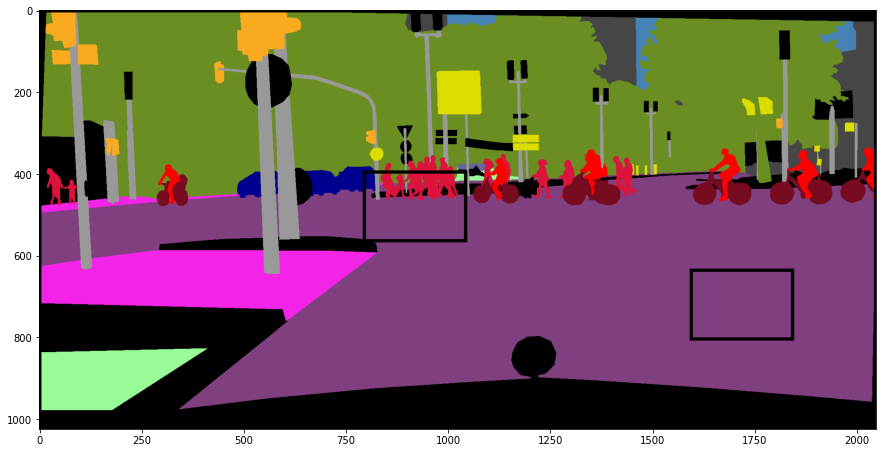

In [36]:
import matplotlib.pyplot as plt
import torch
from mmseg.models.utils.dalle_d_vae import get_dalle_vae, map_pixels, unmap_pixels, encode_to_segmap, decode_from_segmap
plt.figure(figsize=(15,10))
gt_seg_map = draw_segmap_from_indice(gt_semantic_seg)
pred_seg_map = draw_segmap_from_indice(semantic_seg_pred)

road_patch = gt_seg_map[80 * 8:100 * 8, 200 * 8:230 * 8, :].clone()
gt_seg_map[79 * 8:101 * 8, 199 * 8:231 * 8, :] = 0
gt_seg_map[80 * 8:100 * 8, 200 * 8:230 * 8, :] = road_patch

bycicle = gt_seg_map[50 * 8:70 * 8, 100 * 8:130 * 8, :].clone()
gt_seg_map[49 * 8:71 * 8, 99 * 8:131 * 8, :] = 0
gt_seg_map[50 * 8:70 * 8, 100 * 8:130 * 8, :] = bycicle
print(gt_seg_map.shape)
plt.imshow(gt_seg_map)
# print(data['gt_semantic_seg'])

plt.show()

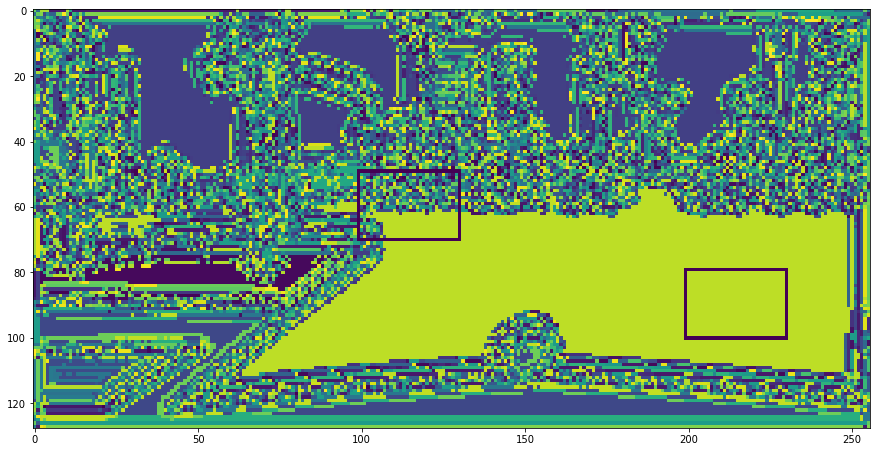

In [7]:
gt_indice = get_gt_vq_indices(gt_semantic_seg).cpu().numpy()

plt.figure(figsize=(15,10))
road_patch = gt_indice[0,80:100, 200:230].copy()
gt_indice[0,79:101, 199:231] = 0
gt_indice[0,80:100, 200:230] = road_patch

bycicle = gt_indice[0,50:70, 100:130].copy()
gt_indice[0,49:71, 99:131] = 0
gt_indice[0,50:70, 100:130] = bycicle
plt.imshow(gt_indice[0])

plt.show()

In [27]:
gt_indice = get_gt_vq_indices(gt_semantic_seg).cpu().numpy()
h, w = gt_indice.shape[-2:]

road_patch = gt_indice[0,80:100, 200:230].copy()
# gt_indice[0,79:101, 199:231] = 0
# gt_indice[0,80:100, 200:230] = road_patch

# bycicle = gt_indice[0,50:70, 100:130].copy()
# gt_indice[0,49:71, 99:131] = 0
gt_indice[0,50:70, 100:130] = road_patch

gt_pixel_segmap = d_vae.decode(torch.tensor(gt_indice), img_size=[h, w])
gt_pixel_segmap = unmap_pixels(torch.sigmoid(gt_pixel_segmap[:, :3])) * 255
gt_pixel_1 = decode_from_segmap(gt_pixel_segmap)
# plt.show()

/tmp/ipykernel_78615/4222723198.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return encode_to_segmap(F.interpolate(torch.tensor(indice).float(), size=data['gt_semantic_seg'].shape[-2:], mode='nearest'))[0].permute(1, 2, 0)


torch.Size([1024, 2048, 3])


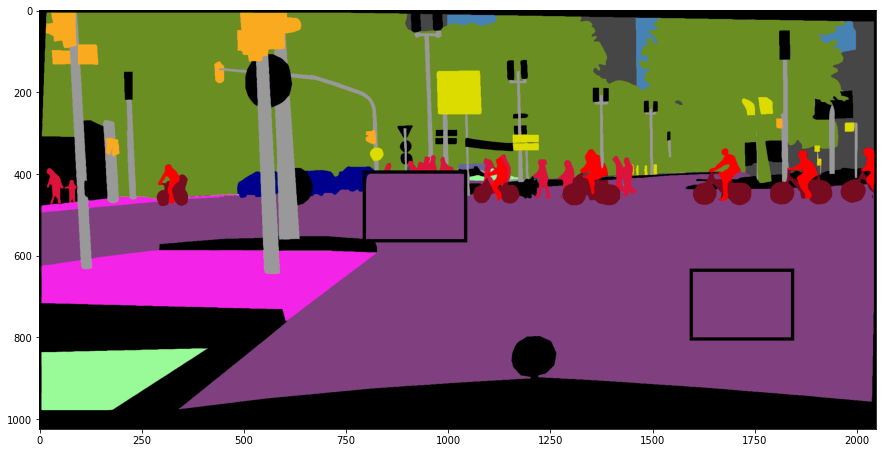

In [32]:
plt.figure(figsize=(15,10))
pic_1 = draw_segmap_from_indice(gt_pixel_1)
road_patch = pic_1[80 * 8:100 * 8, 200 * 8:230 * 8, :].clone()
pic_1[79 * 8:101 * 8, 199 * 8:231 * 8, :] = 0
pic_1[80 * 8:100 * 8, 200 * 8:230 * 8, :] = road_patch

bycicle = pic_1[50 * 8:70 * 8, 100 * 8:130 * 8, :].clone()
pic_1[49 * 8:71 * 8, 99 * 8:131 * 8, :] = 0
pic_1[50 * 8:70 * 8, 100 * 8:130 * 8, :] = bycicle

print(pic_1.shape)
plt.imshow(pic_1.cpu().detach().numpy())


plt.show()
# print(gt_pixel_segmap[0].permute(1, 2, 0).cpu().detach().numpy())

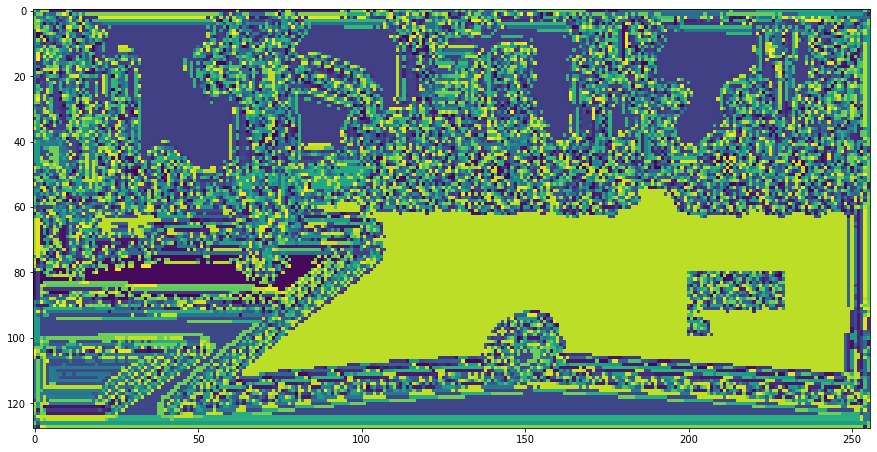

In [21]:
gt_indice = get_gt_vq_indices(gt_semantic_seg).cpu().numpy()

plt.figure(figsize=(15,10))
# road_patch = gt_indice[0,80:100, 200:230].copy()
# gt_indice[0,79:101, 199:231] = 0


bycicle = gt_indice[0,50:70, 100:130].copy()
gt_indice[0,80:100, 200:230] = bycicle
# gt_indice[0,49:71, 99:131] = 0
# gt_indice[0,50:70, 100:130] = road_patch
plt.imshow(gt_indice[0])

plt.show()

In [38]:
gt_indice = get_gt_vq_indices(gt_semantic_seg).cpu().numpy()

plt.figure(figsize=(15,10))
# road_patch = gt_indice[0,80:100, 200:230].copy()
# gt_indice[0,79:101, 199:231] = 0


bycicle = gt_indice[0,50:70, 100:130].copy()
gt_indice[0,80:100, 200:230] = bycicle
# gt_indice[0,49:71, 99:131] = 0
# gt_indice[0,50:70, 100:130] = road_patch

gt_pixel_segmap = d_vae.decode(torch.tensor(gt_indice), img_size=[h, w])
gt_pixel_segmap = unmap_pixels(torch.sigmoid(gt_pixel_segmap[:, :3])) * 255
gt_pixel = decode_from_segmap(gt_pixel_segmap)


<Figure size 1080x720 with 0 Axes>

/tmp/ipykernel_78615/4222723198.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return encode_to_segmap(F.interpolate(torch.tensor(indice).float(), size=data['gt_semantic_seg'].shape[-2:], mode='nearest'))[0].permute(1, 2, 0)


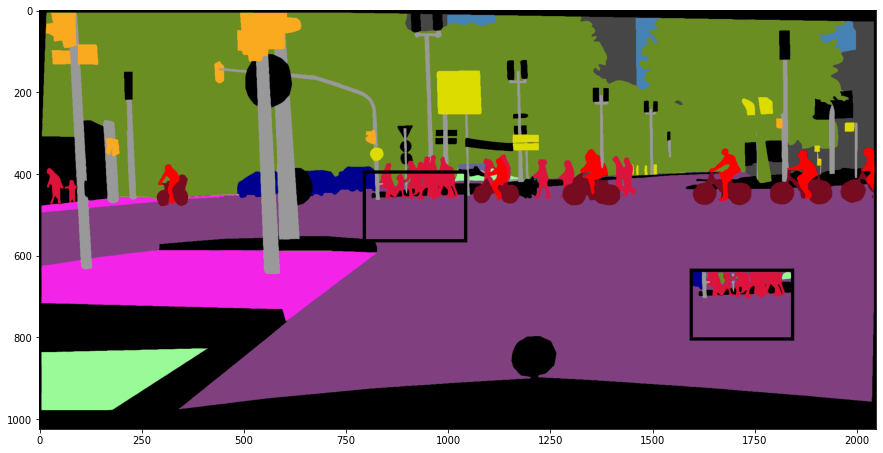

In [37]:
pic_2 = draw_segmap_from_indice(gt_pixel)
road_patch = pic_2[80 * 8:100 * 8, 200 * 8:230 * 8, :].clone()
pic_2[79 * 8:101 * 8, 199 * 8:231 * 8, :] = 0
pic_2[80 * 8:100 * 8, 200 * 8:230 * 8, :] = road_patch

bycicle = pic_2[50 * 8:70 * 8, 100 * 8:130 * 8, :].clone()
pic_2[49 * 8:71 * 8, 99 * 8:131 * 8, :] = 0
pic_2[50 * 8:70 * 8, 100 * 8:130 * 8, :] = bycicle

plt.figure(figsize=(15,10))
plt.imshow(pic_2.cpu().detach().numpy())

plt.show()